In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [8]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    def policy_fn(observation):
        
        # this is the where you give a probability ε/n to every possible action
        action_probs = np.ones(nA) * epsilon / nA

        # and probability of 1-ε + ε/n for the best one.
        best_action = np.argmax(Q[observation])
        action_probs[best_action] = 1 - epsilon + (epsilon / nA)
        return action_probs

        

    return policy_fn

In [31]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy_count = 0
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this! --------------------------------------------------------
    
    # compute the new policy you want to follow using make_epsilon_greedy_policy from your present Q function
    # compute the new Q function based on a set of episodes sampled from the environment based on the new policy.
    # Sample episodes from the environment based on the new policy 
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            print(epsilon)
            sys.stdout.flush()

        episode = []
        state = env.reset()
        
        # Generate an episode of random(based on epsilon policy) actions until game finish.
        # An episode is an array of (state, action, reward) tuples
        for t in range(100):
            
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            
            if done:
                break

            state = next_state
            
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        state_action_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in state_action_in_episode:
            
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            
            # Calculate average return for this state over all sampled episodes
            sa = (state, action)
            returns_sum[sa] += G
            returns_count[sa] += 1.0
            Q[state][action] = returns_sum[sa] / returns_count[sa]
            policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
            policy_count +=1

        
        # The policy is improved implicitly by changing the Q dictionary
    print('\npolicy was updated: ',policy_count )
    print(policy_count)
    #total number of policy improvement cycles
    print("policy improvement ", sum(returns_count.values()))
    return Q, policy

In [33]:
start = time.process_time()

Q, policy = mc_control_epsilon_greedy(env, num_episodes=1000000, epsilon=0.1)

end = time.process_time()
print("\n",end - start,"s")

Episode 1000/1000000.0.1
Episode 2000/1000000.0.1
Episode 3000/1000000.0.1
Episode 4000/1000000.0.1
Episode 5000/1000000.0.1
Episode 6000/1000000.0.1
Episode 7000/1000000.0.1
Episode 8000/1000000.0.1
Episode 9000/1000000.0.1
Episode 10000/1000000.0.1
Episode 11000/1000000.0.1
Episode 12000/1000000.0.1
Episode 13000/1000000.0.1
Episode 14000/1000000.0.1
Episode 15000/1000000.0.1
Episode 16000/1000000.0.1
Episode 17000/1000000.0.1
Episode 18000/1000000.0.1
Episode 19000/1000000.0.1
Episode 20000/1000000.0.1
Episode 21000/1000000.0.1
Episode 22000/1000000.0.1
Episode 23000/1000000.0.1
Episode 24000/1000000.0.1
Episode 25000/1000000.0.1
Episode 26000/1000000.0.1
Episode 27000/1000000.0.1
Episode 28000/1000000.0.1
Episode 29000/1000000.0.1
Episode 30000/1000000.0.1
Episode 31000/1000000.0.1
Episode 32000/1000000.0.1
Episode 33000/1000000.0.1
Episode 34000/1000000.0.1
Episode 35000/1000000.0.1
Episode 36000/1000000.0.1
Episode 37000/1000000.0.1
Episode 38000/1000000.0.1
Episode 39000/1000000

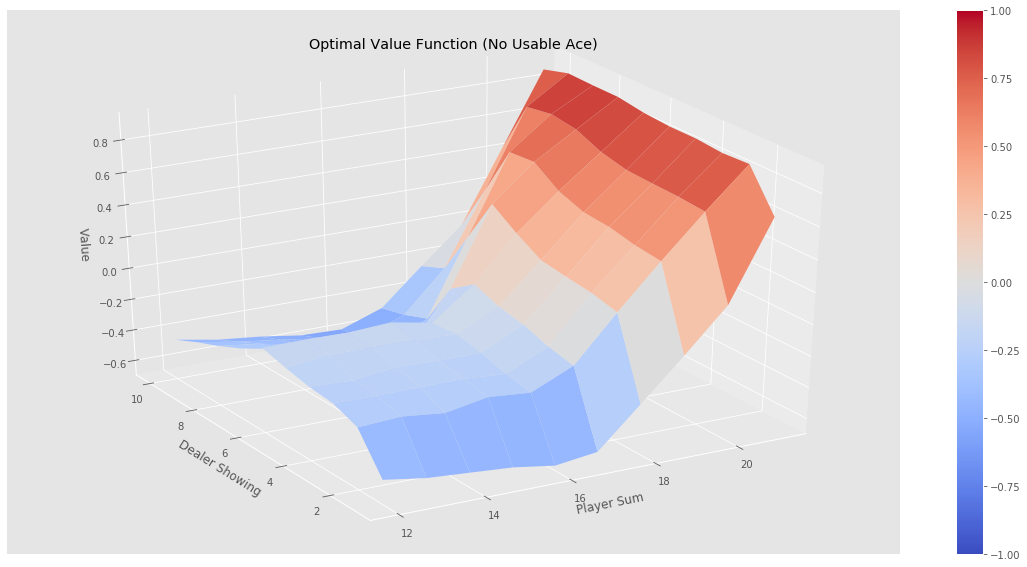

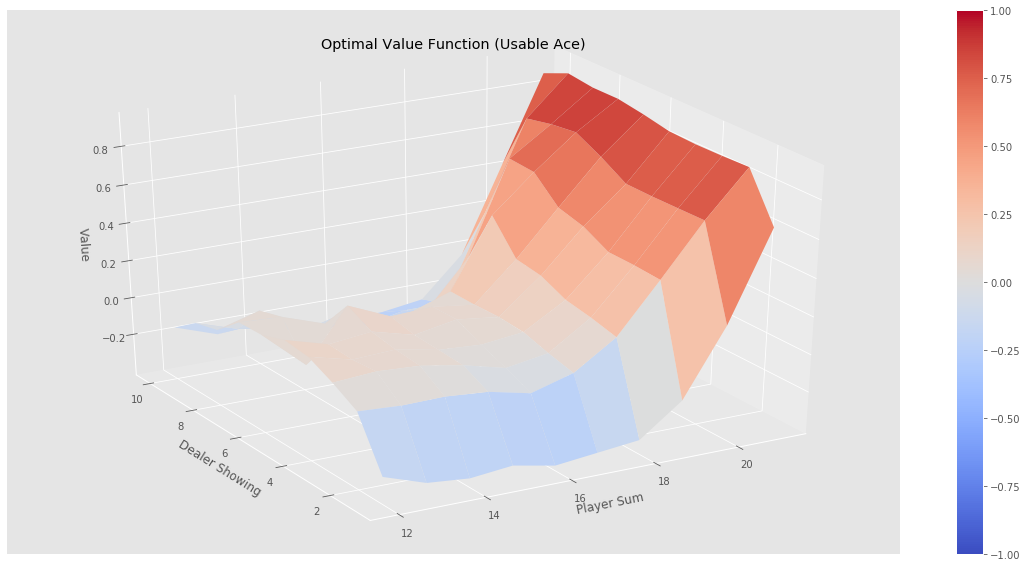

In [34]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")